<a href="https://colab.research.google.com/github/jenelaineDC/Natural-Language-Processing/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### SPAM DETECTION

#### Set-up

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# model evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

# word cloud
from wordcloud import WordCloud

#### Development Process

##### Data Source

In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("shantanudhakadd/email-spam-detection-dataset-classification")
csv_file = os.path.join(path, "spam.csv")

# Load the CSV into a DataFrame
df = pd.read_csv(csv_file, encoding='ISO-8859-1')

# Preview the DataFrame
df.head()

Using Colab cache for faster access to the 'email-spam-detection-dataset-classification' dataset.


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


##### Data Cleaning

In [ ]:
# Drop columns Unnamed: 2/3/4
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

# Rename Columns
df = df.rename(columns = {'v1': 'label', 'v2' : 'message'})
df.columns

Index(['label', 'message'], dtype='object')

In [ ]:
# Check for duplicates and Drop duplicates
print(df.duplicated().sum())
df = df.drop_duplicates(keep = 'first')
print(df.duplicated().sum())

403
0


In [ ]:
# Check Class Balance
df.value_counts('label', normalize='True')

,proportion
label,
ham,0.87367
spam,0.12633


##### Label Encoding

In [ ]:
# Label Encode column label
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


##### Feature Engineering

Create the following columns
- Number of Characters
- Number of Words
- Number of Sentence

In [ ]:
!pip install -q spacy
import spacy
nlp = spacy.load("en_core_web_sm")



In [ ]:
# Number of characters
df['num_characters'] = df['message'].apply(len)


def count_tokens(text):
    doc = nlp(text)
    num_words = len([token.text for token in doc])
    num_sentences = len(list(doc.sents))
    return num_words, num_sentences

# Number of Words and Number of Sentences
df[['num_words', 'num_sentences']] = df['message'].apply(
    lambda x: pd.Series(count_tokens(x)))

df.head()


,label,message,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,3
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,31,2
3,0,U dun say so early hor... U c already then say...,49,13,2
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [ ]:
df.describe()

,label,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.339911,2.100987
std,0.332253,58.236293,13.175170,1.456628
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,2.000000
75%,0.000000,117.000000,26.000000,3.000000
max,1.000000,910.000000,196.000000,27.000000


##### Visualization

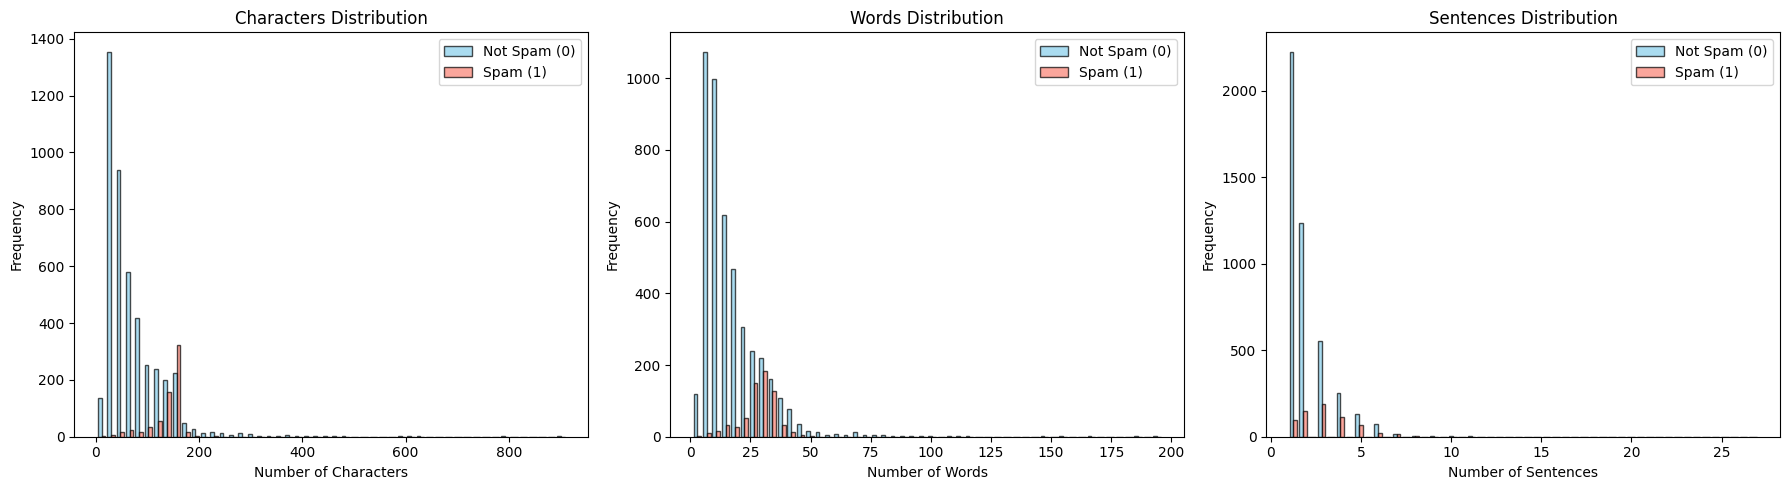

In [ ]:
plt.figure(figsize=(18, 5))

colors = ['skyblue', 'salmon']
labels = ['Not Spam (0)', 'Spam (1)']

# Plot 1: Number of Characters
plt.subplot(1, 3, 1)
plt.hist(
    [df[df['label'] == 0]['num_characters'], df[df['label'] == 1]['num_characters']],
    bins=50,
    label=labels,
    color=colors,
    edgecolor='black',
    alpha=0.7
)
plt.title('Characters Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()

# Plot 2: Number of Words
plt.subplot(1, 3, 2)
plt.hist(
    [df[df['label'] == 0]['num_words'], df[df['label'] == 1]['num_words']],
    bins=50,
    label=labels,
    color=colors,
    edgecolor='black',
    alpha=0.7
)
plt.title('Words Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()

# Plot 3: Number of Sentences
plt.subplot(1, 3, 3)
plt.hist(
    [df[df['label'] == 0]['num_sentences'], df[df['label'] == 1]['num_sentences']],
    bins=50,
    label=labels,
    color=colors,
    edgecolor='black',
    alpha=0.7
)
plt.title('Sentences Distribution')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


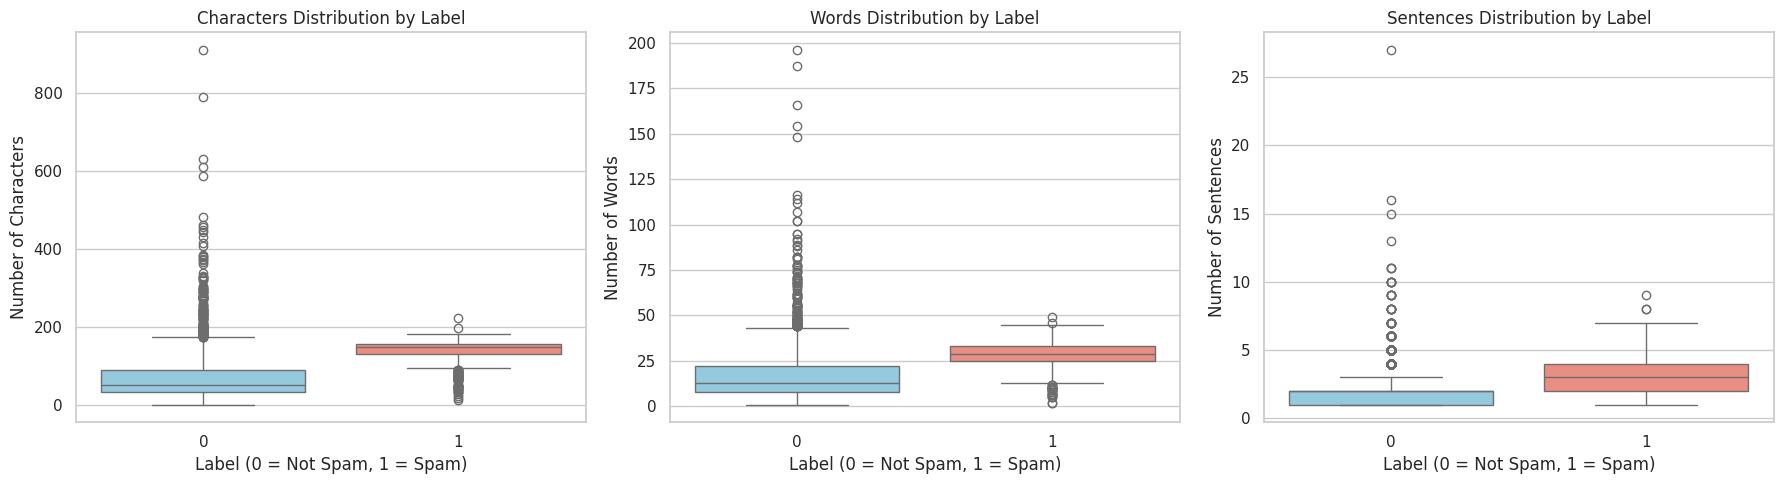

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

# Common color palette
colors = ['skyblue', 'salmon']

# Plot 1: Characters
plt.subplot(1, 3, 1)
sns.boxplot(
    data=df,
    x='label',
    y='num_characters',
    hue='label',
    palette=colors,
    legend=False
)
plt.title('Characters Distribution by Label')
plt.xlabel('Label (0 = Not Spam, 1 = Spam)')
plt.ylabel('Number of Characters')

# Plot 2: Words
plt.subplot(1, 3, 2)
sns.boxplot(
    data=df,
    x='label',
    y='num_words',
    hue='label',
    palette=colors,
    legend=False
)
plt.title('Words Distribution by Label')
plt.xlabel('Label (0 = Not Spam, 1 = Spam)')
plt.ylabel('Number of Words')

# Plot 3: Sentences
plt.subplot(1, 3, 3)
sns.boxplot(
    data=df,
    x='label',
    y='num_sentences',
    hue='label',
    palette=colors,
    legend=False
)
plt.title('Sentences Distribution by Label')
plt.xlabel('Label (0 = Not Spam, 1 = Spam)')
plt.ylabel('Number of Sentences')

plt.tight_layout()
plt.show()


#### Model Development

##### Train - Test Split

In [ ]:
X = df[['message', 'num_characters', 'num_words', 'num_sentences']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
def evaluate_model_metrics(y_true, y_pred):
    """
    Returns a dictionary with accuracy, precision, recall, and F1-score
    """
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }


In [ ]:
models = {
    "MultinomialNB": MultinomialNB(),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVC": SVC(kernel='linear', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


##### Pipeline

In [ ]:
# Vectorizers
vectorizers = {
    "CountVectorizer": CountVectorizer(stop_words='english'),
    "TF-IDF": TfidfVectorizer(stop_words='english')
}

# Store results
results = []

# Loop over vectorizers and models
for vec_name, vectorizer in vectorizers.items():

    # ColumnTransformer with MinMaxScaler to ensure non-negative features
    preprocessor = ColumnTransformer(
        transformers=[
            ('text', vectorizer, 'message'),
            ('num', MinMaxScaler(), ['num_characters', 'num_words', 'num_sentences'])
        ]
    )

    for model_name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Train
        pipeline.fit(X_train, y_train)

        # Predict
        y_pred = pipeline.predict(X_test)

        # Evaluate
        metrics = evaluate_model_metrics(y_test, y_pred)

        # Save to results
        results.append({
            'Model': f"{model_name} + {vec_name}",
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1': metrics['f1']
        })



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:52:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:52:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


##### Model Selection and Evaluation

###### Results Summary

In [ ]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='F1', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df

,Model,Accuracy,Precision,Recall,F1
0,MultinomialNB + CountVectorizer,0.985493,0.967742,0.916031,0.941176
1,SVC + CountVectorizer,0.982592,0.974790,0.885496,0.928000
2,SVC + TF-IDF,0.982592,0.982906,0.877863,0.927419
3,RandomForest + TF-IDF,0.978723,0.990991,0.839695,0.909091
4,RandomForest + CountVectorizer,0.974855,0.990654,0.809160,0.890756
5,XGBoost + CountVectorizer,0.973888,0.964286,0.824427,0.888889
6,XGBoost + TF-IDF,0.971954,0.990385,0.786260,0.876596
7,MultinomialNB + TF-IDF,0.962282,0.989362,0.709924,0.826667
8,KNN + CountVectorizer,0.907157,1.000000,0.267176,0.421687
9,KNN + TF-IDF,0.904255,1.000000,0.244275,0.392638


###### Confusion Matrix

In [ ]:
# Lets recreate the best model based on the highest f1 score in order to produce a confusion matrix
preprocessor = ColumnTransformer(
        transformers=[
            ('text', CountVectorizer(stop_words='english'), 'message'),
            ('num', MinMaxScaler(), ['num_characters', 'num_words', 'num_sentences'])
        ]
    )

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

# Train
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  CountVectorizer(stop_words='english'),
                                                  'message'),
                                                 ('num', MinMaxScaler(),
                                                  ['num_characters',
                                                   'num_words',
                                                   'num_sentences'])])),
                ('classifier', MultinomialNB())])

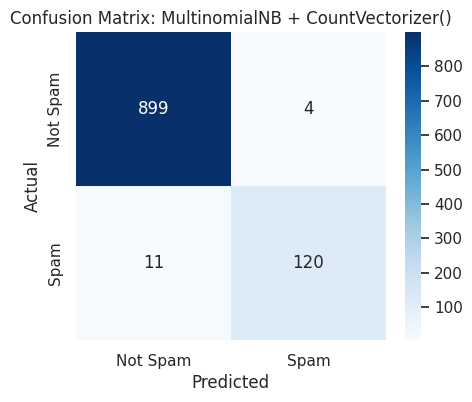

In [ ]:
# Predict
y_pred = pipeline.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Spam', 'Spam'],
            yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix: MultinomialNB + CountVectorizer()')
plt.show()

###### Word Cloud Generation

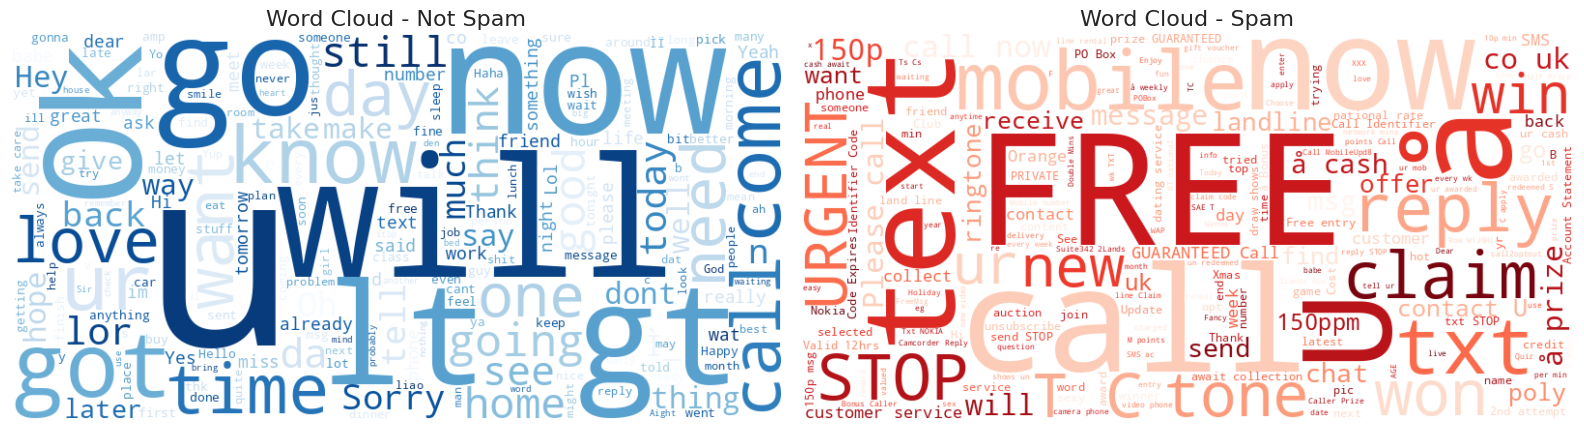

In [ ]:
# Combine all messages for each label
ham_text = " ".join(df[df['label'] == 0]['message'])
spam_text = " ".join(df[df['label'] == 1]['message'])

# Create WordCloud objects
ham_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(spam_text)

# Plot side by side
plt.figure(figsize=(16,8))

# Ham
plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Not Spam', fontsize=16)

# Spam
plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Spam', fontsize=16)

plt.tight_layout()
plt.show()
